In [7]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import special
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import animation, rc
import seaborn as sns
import plotly as py
import plotly.express as px
from datetime import date
from glob import glob
from os.path import join, dirname
import random

from tqdm import tqdm

## import mydef as my Class correction for projects
import mydef

In [2]:
GA = mydef.GA()

OS : linux
Google Drive is detected!
Git directory is detected!


In [3]:
%config InlineBackend.figure_format = 'retina'
py.offline.init_notebook_mode(connected = True)

## Load data

In [4]:
subj = random.sample(GA.list_subj, k=1)[0]
stage = random.sample(['early_practice', 'late_practice'], k=1)[0]
print(subj, stage)

21 late_practice


In [5]:
suffix = 'fmri' if 'early' in stage else ('refmri' if 'late' in stage else 'invalid')
data = scipy.io.loadmat(GA.dir_behav+'/GA%s-%s.mat'%(subj,suffix))

target

In [7]:
for idx, ID in enumerate(data['targetID'][0]):
    if ID == 0:
        continue
    break
targetID = np.array(data['targetID'][0,idx:97*3+idx])

assert targetID[0]==1
assert targetID[-1]==1
assert len(targetID)==97*3

In [8]:
bx = data['boxSize']
pos = bx*GA.convert_ID(targetID)
pos.shape

(2, 291)

60 Hz * {5 s/trial * (1 trial + 12 trial/block * 8 block)}/Run * 7 Run = 203700

In [9]:
data['allXY'].shape

(2, 203700)

60 Hz * {5 s/trial * (1 trial + 12 trial/block * 8 block)}/Run * 3 Run = 87300

In [10]:
allXY = data['allXY'][:, :87300]
allXY.shape

(2, 87300)

In [11]:
xFrame, yFrame = np.array([data['xFrame'].squeeze(), data['yFrame'].squeeze()]).astype(int)

Is it hit?

In [12]:
## target position
temp = np.zeros(allXY.shape)
for i in range(300*97*3):
    t = np.floor(i/300).astype(int)
    temp[0][i], temp[1][i] = pos[0][t], pos[1][t]

In [13]:
err = allXY - temp
hit = np.zeros(300*97*3)
for i in range(300*97*3):
    hit[i] = abs(err[0][i]) <= bx*.5 and abs(err[1][i]) <= bx*.5

---

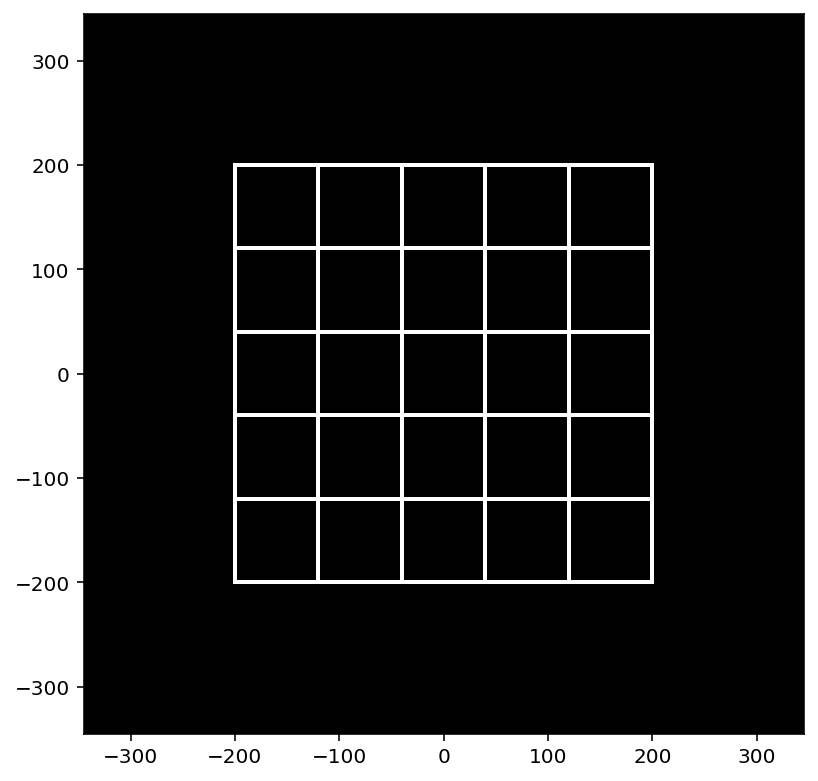

In [14]:
## 1440 * 900
# ratio = [16, 10]
## Square
ratio = [5, 5]
scale = 1
fig = plt.figure(figsize=ratio)
ax = plt.axes(xlim=np.array([-xFrame, xFrame])*ratio[0]/ratio[1]*scale, ylim=np.array([-yFrame, yFrame])*scale)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

## background
ax.set_facecolor((0., 0., 0.))

## grid
for x in [40, 120, 200]:
    for y in [40, 120, 200]:
        ax.plot([x,x], [-y,y], color='w', lw=2)
        ax.plot([-x,-x], [-y,y], color='w', lw=2)
        ax.plot([-x,x], [y,y], color='w', lw=2)
        ax.plot([-x,x], [-y,-y], color='w', lw=2)

live = []

In [15]:
def init():
    line, = ax.plot([], [], color='w', marker='+', markersize=12, lw=3)
    line.set_data([], [])
    
    target_unhit = patches.Rectangle([0, 0], 0, 0, fc='lightgray')
    target_hit = patches.Rectangle([0, 0], 0, 0, fc='crimson')
    
    live.append(line)
    live.append(ax.add_patch(target_unhit))
    live.append(ax.add_patch(target_hit))
    
    return live

In [16]:
## The anchor point (xy)
temp = np.zeros(pos.shape)
temp[0], temp[1] = pos[0] - bx*.5, pos[1] - bx*.5

ap = np.zeros(allXY.shape)
for i in range(300*97*3):
    t = np.floor(i/300).astype(int)
    ap[0][i], ap[1][i] = temp[0][t], temp[1][t]

In [17]:
def animate(i):

    live[0].set_data(allXY[0, i], allXY[1, i])

    if hit[i]:
        live[1].set_width(0)
        live[1].set_height(0)
        live[1].set_xy([ap[0][i], ap[1][i]])
        
        live[2].set_width(bx)
        live[2].set_height(bx)
        live[2].set_xy([ap[0][i], ap[1][i]])
    else:
        live[1].set_width(bx)
        live[1].set_height(bx)
        live[1].set_xy([ap[0][i], ap[1][i]])
        
        live[2].set_width(0)
        live[2].set_height(0)
        live[2].set_xy([ap[0][i], ap[1][i]])

    return live

In [18]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=1200, interval=16.7, blit=True)

Mac:\
`brew isntall ffmpeg`

Debian:
1. Start by updating the packages list:\
`$ sudo apt update`
2. Install the FFmpeg package by running the following command:\
`sudo apt install ffmpeg`

In [19]:
gg = 'GA' if 'early' in stage else ('GB' if 'late' in stage else 'invalid')
print('%s%s'%(gg,subj), stage)

rc('animation', html='html5')
anim

GB21 late_practice


/home/sungbeenpark/anaconda3/envs/sampark/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [20]:
anim.save(join(GA.dir_work,'videos','%s.%s.%s.mp4'%(GA.today, subj, stage))
          , writer = 'ffmpeg', fps=60)

/home/sungbeenpark/anaconda3/envs/sampark/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



---